30558.0
8477.0


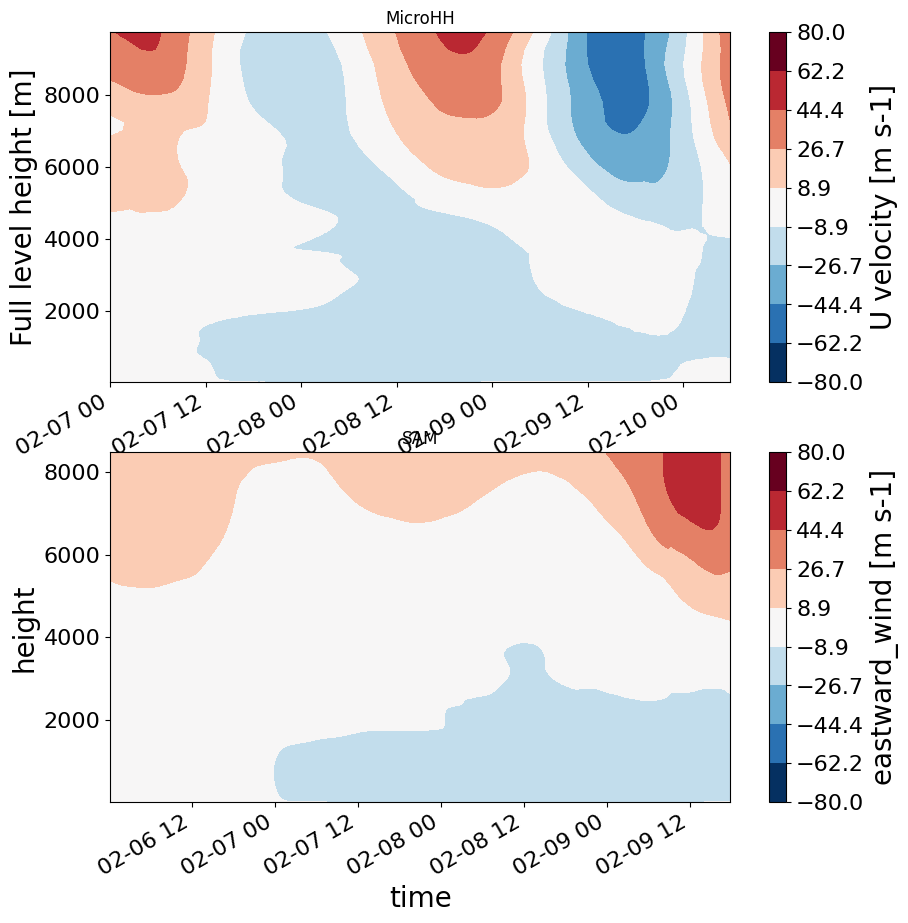

In [15]:
import matplotlib.pyplot as pl
import xarray as xr
import numpy as np
from datetime import datetime, timedelta

pl.rcParams['xtick.labelsize'] = 16
pl.rcParams['ytick.labelsize'] = 16
pl.rcParams['axes.labelsize'] = 20

output1=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/eurec4a_feb9_512_200m_30kmtop_1.nc',decode_times=True)
output2=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_results/EUREC4A_9Jan_144sqx152_100m_SAM_open_sst_kb.nc',decode_times=True)
output3=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200209.kpt.nc',decode_times=True)


new_coords = xr.DataArray(output2['zf'].values, dims='height')
output2=output2.assign_coords({'height':new_coords})


output3=output3.rename({'sfc_sens_flx':'hfss','sfc_lat_flx':'hfls','open_sst':'ts','q':'qv','cloud_fraction':'flc','u':'ua','v':'va'})
output3['hfss']=output3['hfss']*-1; output3['hfls']=output3['hfls']*-1; output3['wspd']=np.sqrt((output3['ua'].isel(nlev=248))**2+(output3['va'].isel(nlev=248))**2)

if 'height_f' in output3.keys():
    new_coords = xr.DataArray(output3['height_f'].isel(time=0).values, dims='nlev')
else:
    new_coords = xr.DataArray(output3['zf'].isel(time=0).values, dims='nlev')
output3=output3.assign_coords({'nlev':new_coords})

output = {'MicroHH':output1,'SAM':output2}
output_3hr={'MicroHH':output1.resample(time='3H').mean(),'SAM':output2.resample(time='3H').mean()}
output_withERA5 = {'MicroHH':output1,'ERA5':output3,'SAM':output2}
output_3hr_withERA5={'MicroHH':output1.resample(time='3H').mean(),'ERA5':output3,'SAM':output2.resample(time='3H').mean()}

vars=['lwp','ps','pr']
vars_withERA5=['hfss','hfls','ts','wspd']



def plot_1d(varname):
    pl.figure(figsize=(10, 10))
    for key in output:
        output[key][varname].plot.line(label=key)
    pl.legend(loc="upper center")
    pl.title(varname)

def plot_1d_withERA5(varname):
    pl.figure(figsize=(10, 10))
    for key in output_withERA5:
        output_withERA5[key][varname].plot.line(label=key)
    pl.legend(loc="upper center")
    pl.title(varname)

def plot_1d_from2d(varname,level):
    pl.figure()
    for key in output:
        (output[key].sel(zf=level))[varname].plot.line(label=key)
    pl.legend(loc="upper center")
    pl.title(varname)

def plot_1d_timeavg(varname,with_ERA5=False):
    max_ht=130
    if with_ERA5:
        xr_data=output_3hr_withERA5
    else:   
        xr_data=output_3hr
    #start_time = datetime.fromisoformat(start_time)
    fig, axs = pl.subplots(nrows=4, ncols=2, figsize=(20, 20))
    axs = axs.flatten()
    for i in range(0,8):
        #time=start_time+timedelta(hours=i)
        for key in xr_data:
            if key=='SAM':
                xr_data[key][varname].isel(time=20+i,height=slice(0,max_ht)).plot.line(y='height',label=key,ax=axs[i])
            elif key=='MicroHH':
                xr_data[key][varname].isel(time=28+i,zf=slice(0,max_ht)).plot.line(y='zf',label=key,ax=axs[i])
                axs[i].set_title(xr_data[key]['time'].isel(time=28+i).dt.strftime('%d%m%y%H').values)
            else:
                xr_data[key][varname].isel(time=84+(3*i),nlev=slice(max_ht,249)).plot.line(y='nlev',label=key,ax=axs[i])
        axs[i].legend(loc="upper right")
        if i!=6 and i!=7:
            axs[i].set_xlabel('')

def plot_2d(varname,level,low_value,high_value):
    fig, axs = pl.subplots(nrows=2, ncols=1, figsize=(10, 10))
    axs = axs.flatten()
    i=0;
    for key in output:
        levs=np.linspace(low_value,high_value,10)
        print(output[key]['zf'].max().values)
        if output[key]['zf'].max().values>level:
            max_ht=np.nonzero((output[key]['zf'].values[:]>level))[0][0]
        else:
            max_ht=output[key]['zf'].size
        #max_ht=130
        if key=='SAM':
            output[key][varname].where(output[key][varname]!=0,np.nan).isel(height=slice(0,max_ht)).transpose().plot.contourf(levels=levs,ax=axs[i])
        else:
            output[key][varname].where(output[key][varname]!=0,np.nan).isel(time=slice(288,None),zf=slice(0,max_ht)).transpose().plot.contourf(levels=levs,ax=axs[i])
            axs[i].set_xlabel('')
        axs[i].set_title(key)
        i=i+1;

#for var in vars:
#    plot_1d(var)

#for var in vars_withERA5:
#    plot_1d_withERA5(var)

plot_2d('ua',10000.,-80,80)

#plot_1d_timeavg('qlc',with_ERA5=False)
#plot_1d_from2d('rhoa',10)


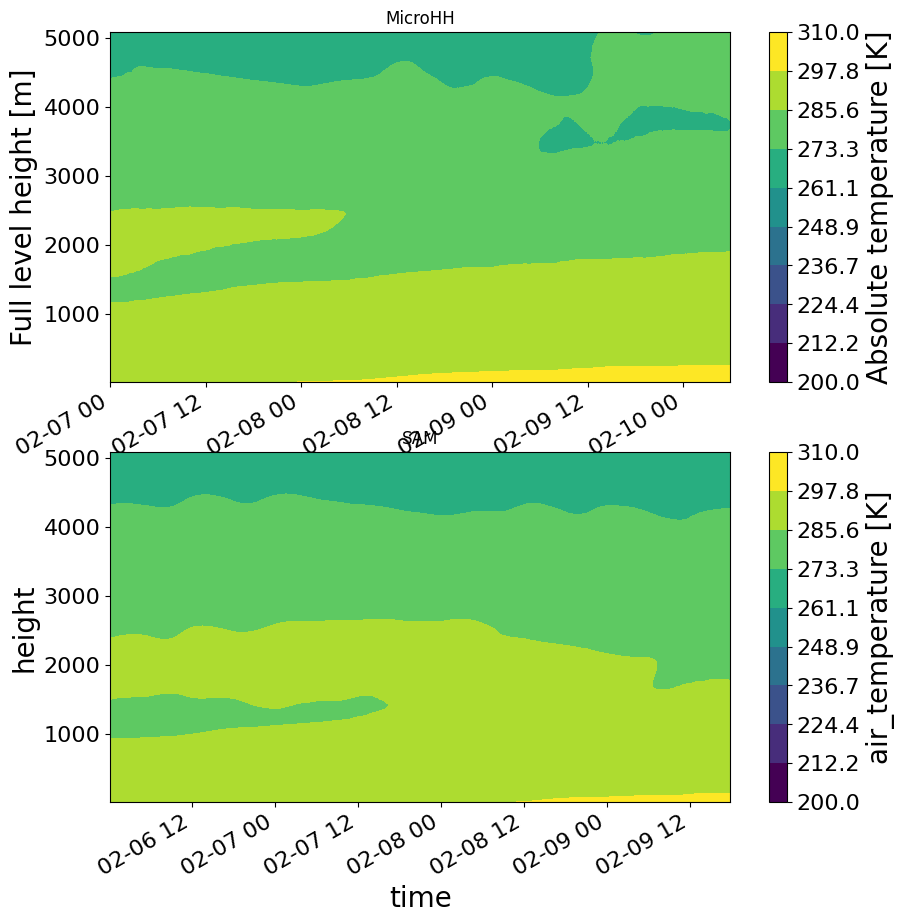

In [3]:
plot_2d('ta',5000.,200,310)

In [ ]:
import datetime
import numpy as np
import eurec4a
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))

def dt64_to_dt(dt64):
    epoch = np.datetime64('1970-01-01T00:00:00')
    second = np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(int((dt64 - epoch) / second))

fig, (ax0, ax1) = plt.subplots(1, 2)

y = ds_sondes_first_circle_Feb05.alt

x0 = ds_sondes_first_circle_Feb05.ta.transpose("alt", "sonde_id")
ax0.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax0.plot(x0, y.data[:, np.newaxis])
ax0.set_xlabel(f"{x0.long_name} / {x0.units}")
ax0.set_ylabel(f"{y.name} / m")
ax0.legend([dt64_to_dt(d).strftime("%H:%M:%S")
            for d in ds_sondes_first_circle_Feb05.launch_time],
           title=x0.launch_time.name)

x1 = ds_sondes_first_circle_Feb05.rh.transpose("alt", "sonde_id")
ax1.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax1.plot(x1, y.data[:, np.newaxis])
ax1.set_xlabel(f"{x1.long_name} / {x1.units}")
ax1.set_ylabel(f"{y.name} / m")
ax1.legend(ds_sondes_first_circle_Feb05.sonde_id.values,
           title="sonde_id")

fig.suptitle('Dropsondes from 1st circle an February 5', fontsize=18)